In [139]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.constants import mu_0
import plotly.graph_objects as go
import warnings

import desc
from desc.transform import Transform
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.plotting import plot_1d,plot_2d,plot_3d,plot_comparison, plot_section, plot_fsa, plot_surfaces, plot_grid
from desc.optimize import Optimizer
from desc.examples import get
from desc.objectives.getters import get_fixed_boundary_constraints, maybe_add_self_consistency
from desc.grid import LinearGrid, QuadratureGrid, Grid
from desc.profiles import PowerSeriesProfile

from desc.backend import jnp
from desc.compute import get_params, get_profiles, get_transforms
from desc.compute.utils import _compute as compute_fun
from desc.nestor import Nestor
from desc.objectives.objective_funs import _Objective
from desc.singularities import (
    DFTInterpolator,
    FFTInterpolator,
    virtual_casing_biot_savart,
    _nonsingular_part,
    _singular_part,
    kernels,
)
from desc.utils import Timer, errorif, warnif

from desc.objectives.normalization import compute_scaling_factors

In [154]:
eq = get("DSHAPE")
eq.pressure = 0
eq.solve();

Building objective: force
Precomputing transforms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Number of parameters: 260
Number of objectives: 756
Starting optimization
Using method: lsq-exact
         Current function value: 4.260e-11
         Total delta_x: 2.792e-01
         Iterations: 100
         Function evaluations: 119
         Jacobian evaluations: 101
Start of solver
Total (sum of squares):  3.326e-03, 
Maximum absolute Force error:  9.631e+03 (N)
Minimum absolute Force error:  8.012e-06 (N)
Average absolute Force error:  1.932e+03 (N)
Maximum absolute Force error:  3.855e-03 (normalized)
Minimum absolute Force error:  3.207e-12 (normali

10201 289
101 60 60
(289, 3)


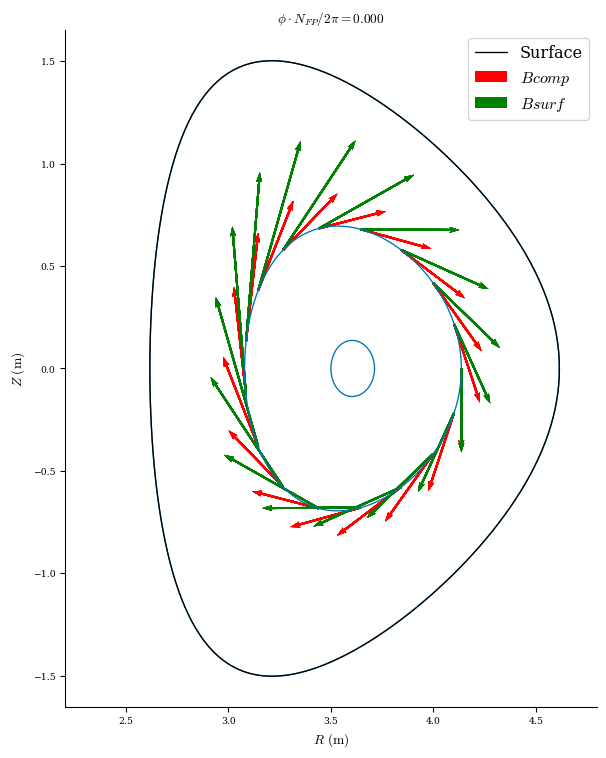

In [162]:
grid_source = LinearGrid(rho=1, M=50, N=50, NFP=int(eq.NFP))
grid_eval = LinearGrid(rho=0.5, M=8, N=8, NFP=int(eq.NFP))
print(grid_source.num_nodes, grid_eval.num_nodes)

keys = [
    "K_vc",
    "B",
    "|B|^2",
    "R",
    "phi",
    "Z",
    "e^rho",
    "n_rho",
    "|e_theta x e_zeta|",
    "p",
    "e^theta"
]
data_source = eq.compute(keys, grid=grid_source)
data_eval = eq.compute(keys, grid=grid_eval)
K_source = data_source["K_vc"]

k = min(grid_source.num_theta, grid_source.num_zeta)
s = k // 2 + int(np.sqrt(k))
q = k // 2 + int(np.sqrt(k))
print(k, s, q)

Bplasma = _nonsingular_part(
        data_eval, grid_eval, data_source, grid_source, s, kernel=kernels["biot_savart"],
    )
Bplasma += data_eval["B"]
print(Bplasma.shape)

scale = 0.2
fig,ax = plot_surfaces(eq,theta=0,rho=np.array([0.1, 0.5, 1.0]),figsize=(8,8),label="Surface",lcfs_color="k")
ax[0].quiver(data_eval["R"],data_eval["Z"],data_eval["B"][:,0],data_eval["B"][:,2],label=r"$Bcomp$",scale=scale,color="r")
ax[0].quiver(data_eval["R"],data_eval["Z"],Bplasma[:,0],Bplasma[:,2],label=r"$Bsurf$",scale=scale,color="g")
ax[0].set_xlim([2.2,4.8])
ax[0].legend(fontsize=12)
fig=plt.gcf()

2401 81


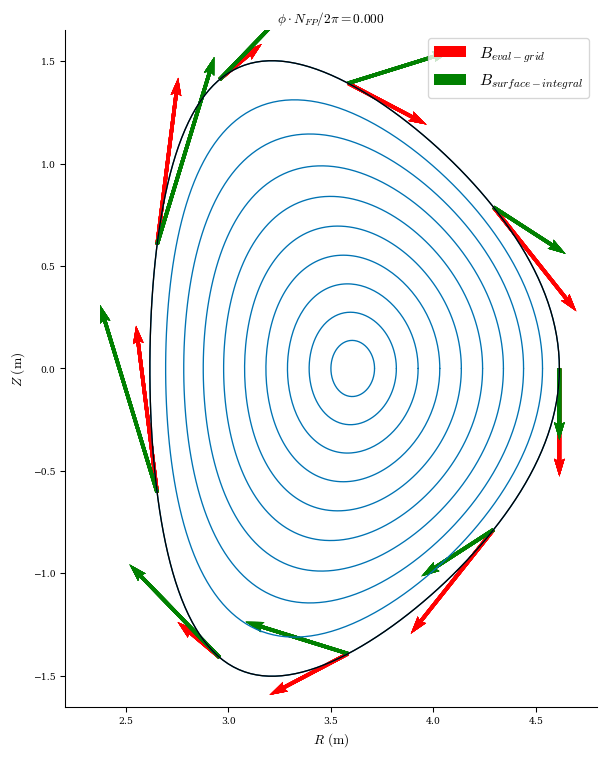

In [161]:
grid_source = LinearGrid(rho=1, M=24, N=24, NFP=int(eq.NFP))
grid_eval = LinearGrid(rho=1, M=4, N=4, NFP=int(eq.NFP))
print(grid_source.num_nodes, grid_eval.num_nodes)

keys = [
    "K_vc",
    "B",
    "|B|^2",
    "R",
    "phi",
    "Z",
    "e^rho",
    "n_rho",
    "|e_theta x e_zeta|",
    "p",
    "e^theta"
]
data_source = eq.compute(keys, grid=grid_source)
data_eval = eq.compute(keys, grid=grid_eval)
K_source = data_source["K_vc"]

k = min(grid_source.num_theta, grid_source.num_zeta)
s = k // 2 + int(np.sqrt(k))
q = k // 2 + int(np.sqrt(k))

interpolator = FFTInterpolator(grid_eval, grid_source, s, q)

Bplasma = _singular_part(data_eval, grid_eval, data_source, grid_source, s, q, kernels["biot_savart"], interpolator, loop=False)
Bplasma += _nonsingular_part(data_eval, grid_eval, data_source, grid_source, s, kernel=kernels["biot_savart"])
Bplasma += data_eval["B"]/2

scale = 0.15
fig,ax = plot_surfaces(eq,theta=0,rho=np.arange(0.1,1.01,0.1),figsize=(8,8),lcfs_color="k")
# ax[0].quiver(data_source["R"],data_source["Z"],data_source["B"][:,0],data_source["B"][:,2],label=r"$B_{original}$",scale=scale,color="b")
ax[0].quiver(data_eval["R"],data_eval["Z"],data_eval["B"][:,0],data_eval["B"][:,2],label=r"$B_{eval-grid}$",scale=scale,color="r")
ax[0].quiver(data_eval["R"],data_eval["Z"],Bplasma[:,0],Bplasma[:,2],label=r"$B_{surface-integral}$",scale=scale,color="g")
ax[0].set_xlim([2.2,4.8])
ax[0].legend(fontsize=12)
fig=plt.gcf()

In [143]:
data = eq.compute(["B"], grid=source_grid)
data.keys()

dict_keys(['rho', 'psi_r', 'iota_den', 'iota_num vacuum', 'iota_num current', 'iota_num', 'iota', 'R', 'R_r', 'Z_r', '0', 'omega_r', 'zeta', 'omega', 'phi', 'e_rho', 'R_t', 'Z_t', 'omega_t', 'e_theta', 'R_z', 'Z_z', 'omega_z', 'e_zeta', 'sqrt(g)', 'B0', 'lambda_z', 'B^theta', 'lambda_t', 'B^zeta', 'B'])

In [ ]:
# # to reduce repeated code, 3D quantities can be converted to xyz basis here.
# # Assumes every 3D quantity is in rpz basis.
# for name in names:
#     if (
#         data_index[parameterization][name]["dim"] == 3  # it should be 3D
#         and kwargs.get("basis", "rpz") == "xyz"  # user should ask in xyz
#         # and ("xy" not in name.lower())  # not already in xyz (naming specify this)
#         # and name.lower() not in {"x", "y", "z"}  # some basic exceptions
#         and ("phi" in data)  # phi is needed for conversion
#         # and data_index[parameterization][name]["coordinates"] == "rtz"
#     ):
#         from .geom_utils import rpz2xyz_vec

#         data[name] = rpz2xyz_vec(data[name], phi=data["phi"])